In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from skimage import color
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

from src.ColorNN import ColorNN

device used : cuda


In [2]:
class CustomFlowersDataset(Dataset):
	def __init__(self, root, split="train", transform=None, download=False):
		self.flowers_dataset = Flowers102(root=root, split=split, download=download)
		self.transform = transform

	def __getitem__(self, index):
		image, _ = self.flowers_dataset[index]
		if self.transform is not None:
			image = self.transform(image)
		return image[0:1,...], image

	def __len__(self):
		return len(self.flowers_dataset)


In [3]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((200,200), antialias=True),
])

train_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=True)
test_dataset = CustomFlowersDataset(root=root_dir, split="test", transform=transform, download=True)

Train dataset size: 1020
Test dataset size: 6149
Images shapes :torch.Size([1, 200, 200]) (input), torch.Size([3, 200, 200]) (target)


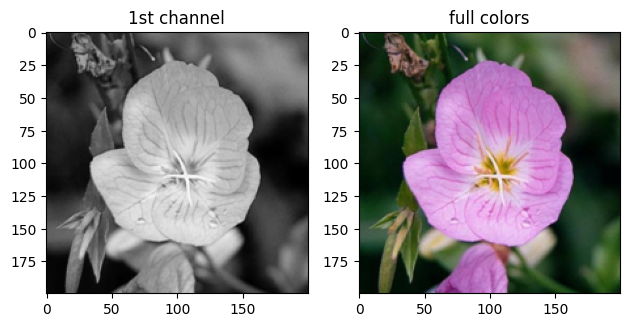

In [4]:
def tensorToImg(tensor:torch.Tensor):
	return tensor.moveaxis(0,2).detach().cpu().numpy()

print("Train dataset size:",len(train_dataset))
print("Test dataset size:",len(test_dataset))
img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input), {img2.shape} (target)")
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(tensorToImg(img1), cmap="grey")
ax1.set_title("1st channel")
ax2.imshow(color.lab2rgb(tensorToImg(img2)))
ax2.set_title("full colors")
plt.tight_layout()

In [15]:
import numpy as np

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
	model = model.to(device)
	# size = len(dataloader.dataset)

	model.train()
	
	for batch, (X, y) in enumerate(dataloader):
		# torch.cuda.empty_cache()
		# Compute prediction and loss
		if len(X.shape) == 3:
			X = X.unsqueeze(0)
		if len(y.shape) == 3:
			y = y.unsqueeze(0)
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 100 == 0 and verbose:
			loss, current = loss.item(), (batch + 1) * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{1:>5d}]")

# img print
def print_imgs(model, dataset):
	fig = plt.figure()
	axes = fig.subplots(3, 3)
	for ax1,ax2,ax3 in axes:
		i = np.random.randint(len(dataset))
		img1, img2 = dataset[i]
		out = model(img1.unsqueeze(1).to(device))
		ax1.imshow(img1.moveaxis(0, 2), cmap="grey")
		ax2.imshow(color.lab2rgb(out.squeeze(0).detach().moveaxis(0, 2).cpu()))
		ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))

	plt.tight_layout()

### Overfit test

In [6]:
model = ColorNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

imgs = [train_dataset[i] for i in range(10)]
for t in range(500):
    if t%10 == 0 : print(".", end="")
    train_loop(imgs, model, criterion, optimizer, verbose=False)
print("\nDone!")

..................................................
Done!


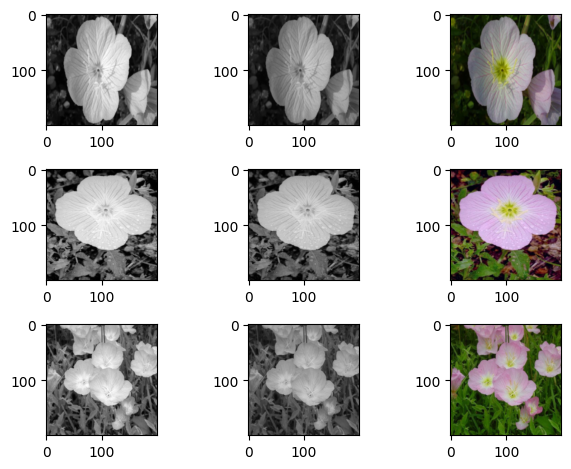

In [16]:
print_imgs(model, imgs)

### Main test

In [ ]:
# Define the model
model = ColorNN()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Dataloaders
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test_dataset, shuffle=True, batch_size=64)

# Set the number of epochs
num_epochs = 10

train_acc = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, criterion, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 398.268219  [   64/ 1020]


KeyboardInterrupt: 

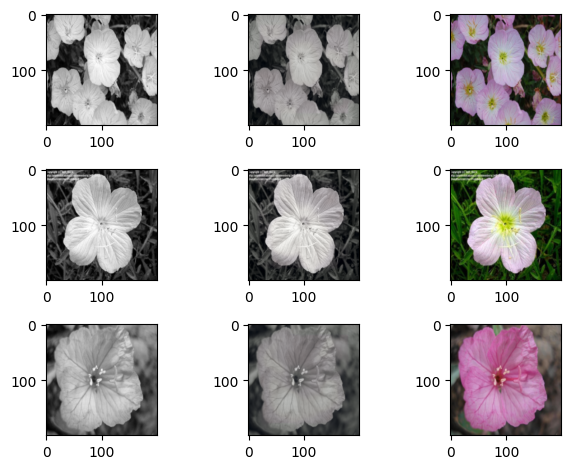

In [ ]:
print_imgs(model, train_dataset)